# **Final homework**

by Titipat Achakulvisut

## **Dynamic programming**

Create a simple 8 X 1 grid world, such that the reward in every entry is -1 except for the `home` square in the top which has a reward of 0. In this world the possible moves are up or down. Moving down in the bottommost square keeps you in the same square. If you reach the `home` square, then you automatically `win` and receive the `0` reward – i.e. once you reach `home` you can never move out of it.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n_states = 8
n_actions = 2

a) **Policy Evaluation**: Assume a random policy – i.e. your probability of moving up or down is 0.5 in every square. Use dynamic programming to find the value function for this policy. Use the Bellman equation explicitly and iteratively to find the value for each square. After each iteration you will get closer and closer to correct value function.

In [3]:
# rewards
r = np.ones(n_states)*-1.0
r[0] = 0.

In [4]:
# probability of each action from one state to another
P = np.zeros((n_states, n_actions, n_states))

In [5]:
# up action
for s in range(n_states):
    for a in range(n_actions):
        if s == 0: # top action when at top
            P[s, a, s] = 1.
        elif s == n_states-1 and a == 1: # bot action when at bottom
            P[s, a, s] = 1.
        else:
            P[s, a, s+(a*2-1)] = 1.

In [6]:
# random policy
Pi = np.ones((n_states, n_actions))*0.5

In [7]:
def v_evaluate(v, r, P, Pi):
    """One iteration of policy evaluation"""
    return (Pi * P.dot(r + v)).sum(1)

def policy_evaluation(v, r, P, Pi, threshold=1e-3):
    """Policy evaluation
    v: initial value estimates
    r: reward of each state
    P: transition matrices (n_states, n_actions, n_states)
    Pi: policy (n_states, n_actions)
    """
    # store values
    all_v = []
    # run policy evaluation
    continue_evalutation = True
    while continue_evalutation:
        new_v = v_evaluate(v, r, P, Pi)
        mse = np.sqrt(np.mean((v - new_v)**2))
        all_v.append(new_v)
        if mse <= threshold:
            continue_evalutation = False
        v = new_v
    return v, np.vstack(all_v)

In [8]:
# initial values
v = np.zeros(n_states)
v, all_v = policy_evaluation(v, r, P, Pi)

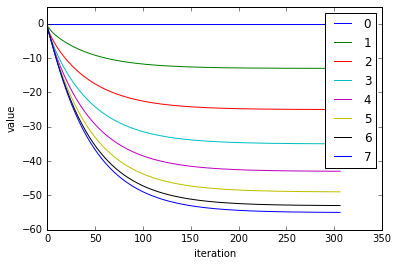

In [9]:
plt.plot(np.vstack(all_v));
plt.legend(range(8));
plt.xlabel('iteration');
plt.ylabel('value');
plt.ylim([-60, 5]);

here, we can see that the value converge to minus value and proportional to how far it is to the home state.

b) **Policy iteration**: Now use dynamic programming to find the optimal policy. Start with a random policy, as in (a). Perform policy evaluation , as in (a), until it converges. Now update the policy based on this value function by being greedy – for each square, update your policy by assigning a probability of 1 to the action (up/down) according to whichever action has a higher expected value. If both actions would result in equal expected values, assign them equal 0.5 probabilities. Then repeat policy evaluation again, using this new policy. Keep iterating between policy evaluation and policy

In [10]:
def greedy_policy_update(v, r, P, Pi):
    # get best action for each state
    state_action_values = P.dot(r + v)
    # generate new policy with deterministic transition
    new_Pi = np.zeros((n_states, n_actions))
    for s in range(n_states):
        if state_action_values[s, 0] == state_action_values[s, 1]:
            new_Pi[s, :] = 1./2
        elif state_action_values[s, 1] > state_action_values[s, 0]:
            new_Pi[s, 1] = 1.
        else:
            new_Pi[s, 0] = 1.
    return new_Pi

In [11]:
# policy iteration
Pi = 0.5 * np.ones((n_states, n_actions))
v = np.zeros(n_states)
print("Initial policy")
print(Pi)
continue_pi = True
while continue_pi:
    v, _ = policy_evaluation(v, r, P, Pi)
    new_Pi = greedy_policy_update(v, r, P, Pi)
    if (Pi == new_Pi).all(): # if not change, stop
        continue_pi = False
    Pi = new_Pi
    print('new iteration')
print("Final policy")
print(Pi)

Initial policy
[[ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]]
new iteration
new iteration
Final policy
[[ 0.5  0.5]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]]


c) Repeat (b) but don’t do policy evaluation until it converges. Just iterate policy evaluation 2 twice each time. Then repeat policy evaluation and policy improvement until you converge on the optimal policy (and expected value function).

In [12]:
# simple policy iteration
Pi = 0.5 * np.ones((n_states, n_actions))
v = np.zeros(n_states)
print("Initial policy")
print(Pi)
continue_pi = True
while continue_pi:
    # run policy evaluation twice
    v  = v_evaluate(v, r, P, Pi)
    v  = v_evaluate(v, r, P, Pi)
    new_Pi = greedy_policy_update(v, r, P, Pi)
    if (Pi == new_Pi).all(): # if not change, stop
        continue_pi = False
    Pi = new_Pi
    print("New iteration")
print("Final policy")
print(Pi)

Initial policy
[[ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]
 [ 0.5  0.5]]
New iteration
New iteration
New iteration
New iteration
Final policy
[[ 0.5  0.5]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]
 [ 1.   0. ]]


## **Q learning (Reinforcement learning)**

Use the same grid world as in (1), but learn the optimal policy using Q-learning.
Here you will learn the optimal state-action function (`Q(x,u)`).
The idea is to move around the world probabilistically according to the `softmax` 
function – i.e. if all state-action pairs have the same expected value, then you have   equal probability of choosing each action from that state. Then, based on the rewards you experience, update the state-action function according to the update equation we  went through in class.

In [13]:
def softmax(w, temp=1.0):
    """softmax function with temperature, temp
    """
    w = np.array(w)
    e = np.exp(w / temp)
    dist = e / np.sum(e)
    return dist

def weighted_choice(w):
    """random choice from probability distribution in list or array
    """
    w = np.array(w)
    w_cum = np.cumsum(w)
    throw = np.random.rand() * w_cum[-1]
    return np.searchsorted(w_cum, throw)

def choose_action(q):
    """choose action using based on 
    """
    action = weighted_choice(softmax(q))
    return action

In [14]:
n_states = 8
n_actions = 2
n_iter = 100
Q = 0.1 * np.random.rand(n_states, n_actions)
alpha = 0.7
gamma = 0.4

In [15]:
# epochs, because we can get stuck in state 0
for _ in range(100):
    # initial state
    s = np.random.randint(n_states) # pick random initial state
    for _ in range(200):
        # action
        a = choose_action(Q[s])
        # next state
        ns = weighted_choice(P[s, a])
        # receive reward
        reward_received = r[ns]
        # update q value
        Q[s, a] = Q[s, a] + alpha*(reward_received + gamma * max(Q[ns]) - Q[s, a])

In [16]:
print("Final Q values \n", Q)

Final Q values 
 [[  3.12008526e-230   1.51869297e-230]
 [  4.29404614e-213  -1.40000000e+000]
 [ -1.00000000e+000  -1.56000000e+000]
 [ -1.40000000e+000  -1.62400000e+000]
 [ -1.56000000e+000  -1.64960000e+000]
 [ -1.62400000e+000  -1.65984000e+000]
 [ -1.64960000e+000  -1.66382466e+000]
 [ -1.65984000e+000  -1.66393600e+000]]


We can see that Q-value on left column is always greater than right column which means that we have higher probability to move upward rather than move downward.

## **Optimal control for dynamical system in discrete time**

Take the dynamical system: $x_{t+1} = a * x_t + b * u_t$

with cost function: $g(x,u) = q * x^2 + r * u^2$

Find the control policy: $u = -k * x$ which minimizes the expected total cost for the trajectory. Use the values: $a = .8; b = 1; q = 1; r = 1.$

a. Find the recursive Riccati equations for the gain for this system. This should be the equations in the lecture (if I got it down right) for $p$. You can also derive them again by i) express the total cost to go using the recursive Bellman equation, ii) assume that the optimal value function has a quadratic form $V^{\ast} = p x^2$, iii) substitute this into the Bellman equation, iv) minimize this with respect to u to find the optimal control policy, v) substitute `u*` into the Bellman equation and solve for the gain `p`.

a. Assume we have dynamical system $x_{t+1} = a x_t + b u_t$ and 
cost at each time step $g(x_t, u_t) = q x_t^2 + r u_t^2$
where $g_T (x_T) = q x_T^2$ is final cost.


- Final condition satisfy $V^* (x_{T}) = q x_{T}^2$
- Assume: $V^* (x_{t+1}) = p x_{t+1}^2$
- We will show that $V^* (x_t) $ is quardratic i.e. $V^* = px^2$. 

According to Bellman's equation, 

\begin{equation}
\begin{split}
V^\ast & = \min_{u_t} (g(x_t, u_t) + V^\ast (x_{t + 1}))\\
       & = \min_{u_t} (q x_t^2 + r u_t^2 + p_{t+1} x_{t+1}^2)\\
       & = \min_{u_t} (q x_t^2 + r u_t^2 + p_{t+1} (a x_t + b u_t)^2)
\end{split}
\end{equation}

We want to minimize this cost with respect to control policy $u_t$. We can take derivative of cost function from Bellman's equation with respect to control, 

\begin{equation}
\frac{\partial V(x_t)}{\partial u_t} = 2 r u_t + 2 p_{t+1} (a x_t + b u_t) b = 0
\end{equation}

Solve for optimal control policy denoted by $u_t^\ast$, 

\begin{equation}
\begin{split}
u_t^\ast (r + p_{t+1} b^2) & = - p_{t+1} a b x_t\\
u_t^\ast &= \frac{- p_{t+1} a b}{r + p_{t+1} b^2} x_t
\end{split}
\end{equation}

We can now put this optimal control $u_t^\ast$ bact to Bellman's equation

\begin{equation}
\begin{split}
V^\ast & = q x_t^2 + r (\frac{- p_{t+1} a b}{r + p_{t+1} b^2} x_t)^2 + p_{t+1} (a x_t + b (\frac{- p_{t+1} a b}{r + p_{t+1} b^2} x_t))^2\\
       & = [q + p_{t+1} a^2 - \frac{(p_{t+1} a b)^2}{r + p_{t+1} b^2}] x_t^2
\end{split}
\end{equation}

Here, we now show that $V^\ast (x_t)$ is quadratic, 

\begin{equation}
V^\ast (x_t) = p_t x_t^2
\end{equation}

where

\begin{equation}
p_{t} = q + p_{t+1} a^2 - \frac{(p_{t+1} a b)^2}{r + p_{t+1} b^2}
\end{equation}

which is the Riccati equation

b. Find the steady state optimal control gain, using the Riccati equation. The equation gives $p_{t-1} = f(p_t)$. So initialize $p(T) = q(T)$ , where $T$ is the final time and $q(T)$ is the cost at the final time. Then iterate the Riccati equations backwards until you reach a steady state value. Plot the evolution of $p$ over iterations.

In [17]:
# dynamics constant
a = 0.8
b = 1.0
q = 1.0
r = 1.0

In [18]:
T = 100
p = np.zeros(T)
p[T-1] = q

In [19]:
T = 100
p_list = list()
p_list.append(q)
for t in range(T):
    p_old = p_list[-1]
    p = q + p_old * (a**2) - (p_old * a * b)**2/(r + p_old * (b**2))
    p_list.append(p)
    if np.linalg.norm(p_old - p) < 1e-4: 
        break

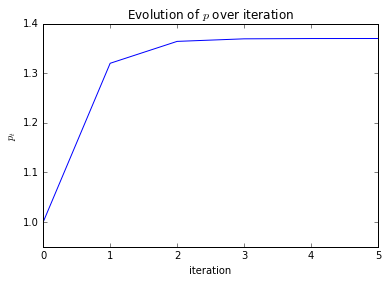

In [20]:
plt.plot(p_list)
plt.title('Evolution of $p$ over iteration')
plt.xlabel('iteration')
plt.ylabel('$p_t$')
plt.show()

The control can be obtained:

\begin{equation}
    u_t^\ast = \frac{-p_{t+1} a b }{r + p_t b^2} x_t
\end{equation}

where control gain, 
\begin{equation}
K = \frac{p_{t+1} a b }{r + p_t b^2}
\end{equation}

in steady state, we can assume that $p_t$ and $p_{t+1}$ converge to the same value

In [21]:
# steady state optimal control gain (compare below with `dare` solver)
p = p_list[-1] 
K = (p * a * b)/((p * b**2) + r)
print('Steady state optimal control gain K = %f' % K)

Steady state optimal control gain K = 0.462439


c. Do control. Choose an arbitrary starting state for $x$ and then evolve your system over time, as dictated by the equations above. At each time step calculate the $u^{\ast}$ according to the optimal control gain found using the Riccati equations above.

In [22]:
T = 50 # says we consider time step of 50
p = np.zeros(T)
u = np.zeros(T)
x = np.zeros(T)
p[T-1] = q
for t in range(T-1, 0, -1):
    p[t-1] = q + p[t] * (a**2) - (p[t] * a * b)**2/(r + p[t] * (b**2))

In [23]:
# find control
x = np.zeros(T)
x[0] = 1
for t in range(T-1):
    u[t] = - (p[t+1] * a * b)/((p[t+1] * b**2) + r) * x[t] # control
    x[t+1] = a * x[t] + b * u[t]

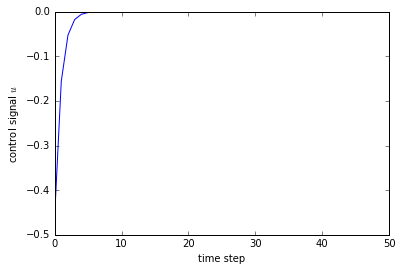

In [24]:
plt.plot(u)
plt.xlabel('time step')
plt.ylabel('control signal $u$')
plt.show()

d. Find the same gains by brute force. Go sequentially through a series of different gains (either $p$ or $K$), simulate the system as in (c) above and calculate the cost for each trajectory. Find the trajectory with the minimal cost. Compare the corresponding gain with that calculated using the Riccati equations above.

In [25]:
x[0] = -1 # arbitrary starting point
for t in range(T-1):
    x[t + 1] = a * x[t]

g = np.zeros(T)
for t in range(T-1):
    g[t] = q * x[t]**2
traj_cost = np.sum(g)
print('Trajectory cost without control signal = %f' % traj_cost)

Trajectory cost without control signal = 2.777778


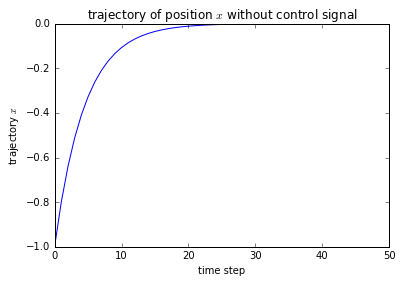

In [26]:
plt.plot(x)
plt.xlabel('time step')
plt.ylabel('trajectory $x$')
plt.title('trajectory of position $x$ without control signal')
plt.show()

In [27]:
x = np.zeros(T)
x[0] = -1
for t in range(T-1):
    u[t] = - (p[t+1] * a * b)/((p[t+1] * b**2) + r) * x[t]
    x[t+1] = a * x[t] + b * u[t]

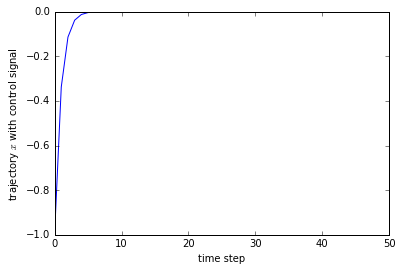

In [28]:
plt.plot(x)
plt.xlabel('time step')
plt.ylabel('trajectory $x$ with control signal')
plt.show()

In [29]:
# calculate cost over trajectory
g = np.zeros(T)
for t in range(T-1):
    g[t] = q * x[t]**2 + r * u[t]**2
traj_cost = np.sum(g)
print('Minimum trajectory cost (applying control) = %f' % traj_cost)

Minimum trajectory cost (applying control) = 1.369952


e. (optional) Find the same gains using matlab. Use the functions `dlqr` and `dare` (discrete time LQR control, discrete time algebraic riccati equations) with the system parameters to find the optimal gains. Compare with the results from above.

In [30]:
def dlqr(a, b, q, r):
    """Solve steady state discrete LQR for 
        x_(t+1) = a x_t + b u_t
    with cost
        g = q x**2 + r u**2
    replicate dlqr in Matlab
    """
    #ref Bertsekas, p.151
    a = np.matrix(a)
    b = np.matrix(b)
    q = np.matrix(q)
    r = np.matrix(r)
    p = np.matrix(scipy.linalg.solve_discrete_are(a, b, q, r))
    K = (p * a * b)/((p * b**2) + r)
    eig_vals, _ = np.linalg.eig(a - b*K)
    return K, p, eig_vals

import scipy.linalg
K, _, _ = dlqr(a,b,q,r)
print('Steady state gain solving by `dlqr` or `discrete_are`, K = %f' % K)

Steady state gain solving by `dlqr` or `discrete_are`, K = 0.462440


Optimal gain in steady state is the same either from `dlqr` (`dare`) equation or solve directly using Riccati equation

## **Optimal estimation using Kalman filtering**

Take second order dynamical system in discrete time:

\begin{align}
x_{t+1} = A * x_t + B * u_t + w_t\\
y_t = C * x_t + v_t
\end{align}

with $E(w_t w_t^T) = Q$ and $E(v_t v_t^T) = R$.

Find the recursive update equations to do optimal estimation, consisting of the iterative steps (b,c,d) below. Use the difference equation:

\begin{equation}
x_{t+2} + 0.9 * x_{t+1} + 0.1 * x_t = u_t
\end{equation}

You should simulate the dynamical system above, propagating the state according the update equation, generating random noise at each iteration (use the multivariate normal function mvnrnd – or just use `normrnd` for each dimension separately and assume that `Q` and `R` are diagonal). Choose different values of Q and R to examine effects of measurement and process noise.

**Ans.** We can write the given equation as follows

$$ \begin{bmatrix}
x_{t+1}\\x_{t+2}
\end{bmatrix} = 
\begin{bmatrix} 0 & 1\\-0.1 & -0.9 \end{bmatrix} 
\begin{bmatrix} x_t \\ x_{t+1} \end{bmatrix}
+ \begin{bmatrix} 0 \\ 1 \end{bmatrix} u_t + w_t $$ 

that is,

$$A = \begin{bmatrix} 0 & 1\\-0.1 & -0.9 \end{bmatrix}, B = \begin{bmatrix} 0 \\ 1 \end{bmatrix}$$

Assuming we can observe position output, we can write,

$$y_t = \begin{bmatrix} 1 & 0 \end{bmatrix} x_t + v_t$$

here, we have $C = \begin{bmatrix} 1 & 0 \end{bmatrix}$

Below, we will propagate the system over `T` iterations

In [31]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
# state transition matrix
A = np.array([[0, 1], [-0.1, -0.9]])
B = np.array([[0], [1]])
C = np.array([[1, 0]])
x0 = np.array([[1], [0]]) # initial position
Q = np.array([[0.001, 0.0], [0.0, 0.001]])
R = np.array([[0.01]])
u = np.array([[0.0]]) # assume no input over iteration for now

In [33]:
T = 30
x = list() # list to collect state over iterations
y = list() # list to collect observed over iterations
x.append(x0)
for i in range(T):
    w_t = np.atleast_2d(np.random.multivariate_normal([0, 0], Q)).T
    v_t = np.atleast_2d(np.random.multivariate_normal([0], R))
    x_t = A.dot(x[-1]) + w_t + B.dot(u)
    y_t = C.dot(x[-1]) + v_t
    x.append(x_t)
    y.append(y_t)
x_all = np.hstack(x).T
y_all = np.hstack(y).T

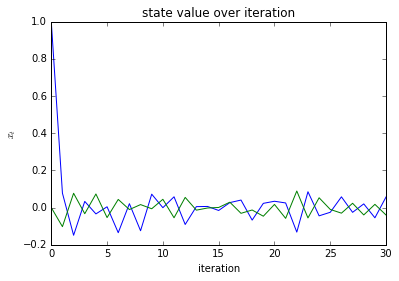

In [34]:
plt.plot(x_all)
plt.xlabel('iteration')
plt.ylabel('$x_t$')
plt.title('state value over iteration')
plt.show()

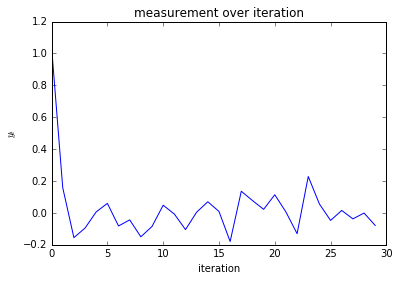

In [35]:
plt.plot(y_all)
plt.xlabel('iteration')
plt.ylabel('$y_t$')
plt.title('measurement over iteration')
plt.show()

a. Choose arbitrary initial guesses for `x` and the confidence in `x`, given by the error covariance `sigma_0`.

In [36]:
sigma_0 = np.array([[0.01, 0.0], [0.0, 0.01]]) # confidence in x
x_est_0 = np.array([[1.5], [0]]) # initial guess for x

b. Propagate the estimates forward in time to get a prediction of the state. These are the equations involving the state transition matrix `A`.

In [37]:
# prediction of the state
x_pred = A.dot(x_est_0) + B.dot(u)
print('Prediction of the state = \n', x_pred)

Prediction of the state = 
 [[ 0.  ]
 [-0.15]]


c. Calculate the Kalman gain.

In [38]:
P = A.dot(sigma_0).dot(A.T) + Q
K = P.dot(C.T).dot(inv(C.dot(P).dot(C.T) + R)) # Kalman gain

In [39]:
print('Kalman gain = \n', K)

Kalman gain = 
 [[ 0.52380952]
 [-0.42857143]]


d. Update the estimates, using the new measurement $y_t$ and the predictions found in b.

In [40]:
x_est = x_pred + K.dot(y[1] - C.dot(x_pred)) # update using new measurement
print('Estimate of state x_t = \n', x_est)

Estimate of state x_t = 
 [[ 0.08287344]
 [-0.21780554]]


e. Repeat the steps b-d as your system evolves. Plot the actual state of the system vs. the state predicted in d, along with the measurements – how much does the estimate pay attention to the measurement noise? Use different values for the measurement noise R to see how the filter switches between being data driven vs. prediction driven.

In [41]:
T = 30
sigma_0 = np.array([[0.01, 0.0], [0.0, 0.01]]) # confidence in x
x_est_0 = np.array([[1.5], [0]]) # initial guess for x

In [42]:
Q = np.array([[0.001, 0.0], [0.0, 0.001]])
R = np.array([[0.01]])
x_est_all = list()
sigma_est_all = list()
x_est_all.append(x_est_0)
sigma_est_all.append(sigma_0)

for t in range(T):
    # update
    x_pred = A.dot(x_est_all[-1]) + B.dot(u)
    P = A.dot(sigma_est_all[-1]).dot(A.T) + Q
    
    # kalman gain
    K = P.dot(C.T).dot(inv(C.dot(P).dot(C.T) + R))
    x_est = x_pred + K.dot(y[t] - C.dot(x_pred))
    sigma_est = (np.eye(2) - K.dot(C)).dot(P)
    
    # append result
    x_est_all.append(x_est)
    sigma_est_all.append(sigma_est)
x_est_all = np.hstack(x_est_all).T

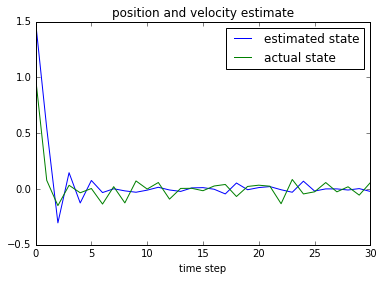

In [43]:
plt.plot(x_est_all[:, 0])
plt.plot(x_all[:, 0])
plt.legend(['estimated state', 'actual state'])
plt.xlabel('time step')
plt.title('position and velocity estimate')
plt.show()

Here, we increase $R$ value, which mean that we rely more one state but not measurement (since the noise is quite high). We get more smooth estimate trajectory as you can see below

In [44]:
Q = np.array([[0.001, 0.0], [0.0, 0.001]])
R = np.array([[0.1]])
x_est_all = list()
sigma_est_all = list()
x_est_all.append(x_est_0)
sigma_est_all.append(sigma_0)

for t in range(T-1):
    # update
    x_pred = A.dot(x_est_all[-1]) + B.dot(u)
    P = A.dot(sigma_est_all[-1]).dot(A.T) + Q
    
    # kalman gain
    K = P.dot(C.T).dot(inv(C.dot(P).dot(C.T) + R))
    x_est = x_pred + K.dot(y[t] - C.dot(x_pred))
    sigma_est = (np.eye(2) - K.dot(C)).dot(P)
    
    # append result
    x_est_all.append(x_est)
    sigma_est_all.append(sigma_est)
x_est_all = np.hstack(x_est_all).T

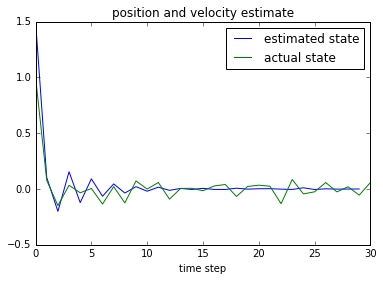

In [45]:
plt.plot(x_est_all[:, 0])
plt.plot(x_all[:, 0])
plt.legend(['estimated state', 'actual state'])
plt.xlabel('time step')
plt.title('position and velocity estimate')
plt.show()

(follow problem 4d) Use different system dynamics to simulate different systems, or add a control signal in there as well to see how it tracks.

We'll try tracking simple dynamical system with accerelation. This is example from Student Dave's on Kalman filter.

\begin{equation}
x_t = x_{t-1} + v_{t-1} t + \frac{1}{2} a_{t} T^2\\
v_t = v_{t-1} + a_{t} T
\end{equation}

\begin{equation}
\mathbf{x}_t = 
\begin{bmatrix} x_t\\ v_t \end{bmatrix} = 
\begin{bmatrix} 1 & T\\ 0 & 1 \end{bmatrix} 
\begin{bmatrix} x_{t-1} \\ v_{t-1} \end{bmatrix} 
+ \begin{bmatrix} T^2 \\ T \end{bmatrix} u_t + w_t 
\end{equation}

we assume measurement is just position

$$y_t = \begin{bmatrix} 1 & 0 \end{bmatrix} \mathbf{x}_t + v_t$$

where $T$ is time step in second before we measure position again.

First, we will simulate the system.

In [46]:
# state transition matrix
dt = 0.1
t_total = 8
A = np.array([[1, dt], [0, 1]])
B = np.array([[dt**2], [dt]])
C = np.array([[1, 0]])
x0 = np.array([[0], [0]]) # initial position
Q = np.array([[0.5, 0.0], [0.0, 0.5]])
R = np.array([[15]])
u = np.array([[1.5]]) # control affect acceleration

In [47]:
x = list() # list to collect state over iterations
y = list() # list to collect observed over iterations
x.append(x0)
for i in range(100):
    w_t = np.atleast_2d(np.random.multivariate_normal([0, 0], Q)).T
    v_t = np.atleast_2d(np.random.multivariate_normal([0], R))
    x_t = A.dot(x[-1]) + w_t + B.dot(u)
    y_t = C.dot(x[-1]) + v_t
    x.append(x_t)
    y.append(y_t)
x_all = np.hstack(x).T
y_all = np.hstack(y).T

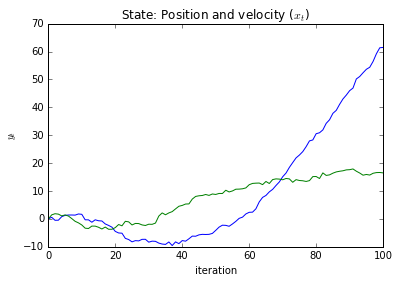

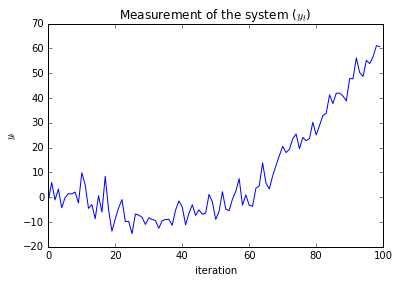

In [48]:
plt.plot(x_all)
plt.xlabel('iteration')
plt.ylabel('$y_t$')
plt.title('State: Position and velocity ($x_t$)')
plt.show()

plt.plot(y_all)
plt.xlabel('iteration')
plt.ylabel('$y_t$')
plt.title('Measurement of the system ($y_t$)')
plt.show()

now, we will perform Kalman filter to estimate state

In [49]:
x_est_all = list()
sigma_est_all = list()
x_est_0 = np.array([[0], [0]])
sigma_0 = np.array([[0.1, 0], [0, 0.1]])
Q = np.array([[0.5, 0.0], [0.0, 0.5]])
R = np.array([[60]])
x_est_all.append(x_est_0)
sigma_est_all.append(sigma_0)

for t in range(100):
    # update
    x_pred = A.dot(x_est_all[-1]) + B.dot(u)
    P = A.dot(sigma_est_all[-1]).dot(A.T) + Q
    
    # Kalman gain
    K = P.dot(C.T).dot(inv(C.dot(P).dot(C.T) + R))
    x_est = x_pred + K.dot(y[t] - C.dot(x_pred))
    sigma_est = (np.eye(2) - K.dot(C)).dot(P)
    
    # append result
    x_est_all.append(x_est)
    sigma_est_all.append(sigma_est)
x_est_all = np.hstack(x_est_all).T

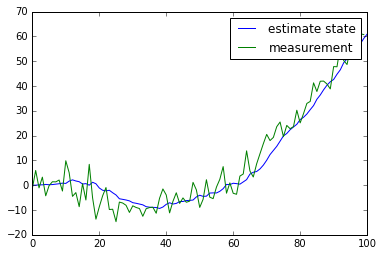

In [50]:
plt.plot(x_est_all[:,0])
plt.plot(y_all)
plt.legend(['estimate state', 'measurement'])
plt.show()

that is, we can estimate state based on Kalman filter. In this case, again, we rely more on state but not measurement since it is pretty noisy.

## **Optimal control for continuous time, second order system**

Take the second order system:

\begin{equation}
a + b v + k x = u
\end{equation}

with acceleration `a`, velocity `v`, position `x`, and driving force `u`, and stiffness `k` and damping `b`. Use the values: `k = 10`, `b = -0.2`. Express the system in state space form:

\begin{equation}
\frac{dx}{dt} = A * x + B * u
\end{equation}

($x$ is a 2 x 1 vector with position and velocity, $A$ is a 2 x 2 matrix with elements
of [0, 1] and b and k, B is a 2 x 1 vector and u is a scalar). Assume quadratic cost function:

\begin{equation}
g(x,u) = x^T Q x + u^T R u
\end{equation}

Find the optimal control policy $u^* = -K * x$ to minimize the above cost.

Do a – d as above. You need the continuous time Riccati matrix equations. We did not cover this in class so you will need to find them. The principle is the same as the DT case though. In this case the Ricatti equations will be a differential equation that calculates the Riccati coefficients, starting from the terminal state then going backwards. This will be a differential equation `Pdot = f(P,A,B,Q,R)`. The procedure is the same though: choose initial conditions `P = Q(T)`, then evolve the system backwards in time using the differential equation – you need to use one of matlab’s differential equation integrators (ode45 should be good) to evolve the system. Give it enough time to reach steady state. Then use this gain to calculate the control gain, using the equations from the lecture. Simulate the system with these gains (again using `ode45` to simulate the system dynamics).


Then figure out the optimal control gains using brute force – `K` is a `2 x 1` vector so go through a series of possible gains (e.g `K(1) = 0:.1:3` and `K(2) = 0:.1:3`) and evaluate the system for each of these gains.

Compare the gains found using each method.


**Ans.** from given equation, we can write down as 
$$\ddot{x} + b \dot{x} + k x = u$$

Therefore, 

$$\frac{d}{dt}\begin{bmatrix}x \\ \dot{x}\end{bmatrix} = 
\begin{bmatrix} 0 & 1 \\ -k & -b \end{bmatrix} \begin{bmatrix}x \\ \dot{x}\end{bmatrix} + \begin{bmatrix}0 \\ 1\end{bmatrix} u_t$$

that is 

$$A = \begin{bmatrix} 0 & 1 \\ -k & -b \end{bmatrix} = \begin{bmatrix} 0 & 1 \\ -10 & -0.2 \end{bmatrix}, B = \begin{bmatrix} 0 \\ 1 \end{bmatrix} $$

Says, we pick quardratic function cost, 

$$g_t(x,u) = x^T Q x + u^T R u = x^T \begin{bmatrix} 10 & 0 \\ 0 & 0.1 \end{bmatrix} + u^T \begin{bmatrix} 1 \end{bmatrix} u$$

that is $Q = \begin{bmatrix} 10 & 0 \\ 0 & 0.1 \end{bmatrix}$ and $R = 1$

Cost over trajectory from $t = 0$ to $t = T$, 

$$L = \int_{t=0}^{t=T} [x^T Q x + u^T R u]dt + x^T Q_T x = \int_{t=0}^{t=T} x^T \begin{bmatrix} 10 & 0 \\ 0 & 0.1 \end{bmatrix} x + u^T \begin{bmatrix} 1 \end{bmatrix} u] dt + x^T Q_T x$$ 

where $Q_T$ is terminal cost that we can select

here, we will choose terminal cost 

$$Q_T = \begin{bmatrix} 0 & 0 \\ 0 & 0 \end{bmatrix}$$

Continuous time Riccati differential equation (RDE) can be written as follows (I don't prove it here, grab from Liberzon, Calculus of Variations and Optimal Control Theory, chapter 6)

$$\dot{P}(t) = - P(t) A(t) - A^T(t) P(t) - Q(t) + P(t) B(t) R^{-1}(t) B^T(t) P(t)$$

In this case, system is linear, we can simplify the equation to, 

$$\dot{P}(t) = - P(t) A - A^T P(t) - Q(t) + P(t) B R^{-1} B^T P(t)$$

a. steady state gain can be derived by algebraic Riccati equation (ARE)

$$PA + A^T P + Q - P B R^{-1} B^{T} P = 0$$ 

which can be solved using Matlab or Python

In [51]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
n_state = 2 # number of states in state equation
A = np.array([[0, 1], [-10., -0.2]])
B = np.array([[0], [1]])
Q = np.array([[10.0, 0.0], [0.0, 0.1]])
R = np.array([[1]])
T = 10

In [53]:
P = solve_continuous_are(A, B, Q, R) # steady state solution of Riccati eq's
K = -(1/R).dot(B.T).dot(P) # steady state gain

In [54]:
print('At steady state, P will converge to \n ', P)
print('Final gain = ', K)

At steady state, P will converge to 
  [[ 9.0805896   0.48808848]
 [ 0.48808848  0.85649277]]
Final gain =  [[-0.48808848 -0.85649277]]


b. we can also solve continuous time Riccati equation as stated above and find the steady state gain

In [55]:
n = T/0.1 + 1
tr = np.linspace(0, -T, n) # reverse time for solving Riccati
PT = np.array([[0, 0], [0, 0]]) # terminal cost

In [56]:
def solve_riccati(P, t):
    """Solve ODE Riccati equation"""
    P = np.reshape(P, (n_state, n_state))
    dPdt = -P.dot(A) - A.T.dot(P) - Q + (1/R)*P.dot(B).dot(B.T).dot(P)
    return dPdt.ravel()

In [57]:
Pt = odeint(solve_riccati, PT.ravel(), tr) # solve Riccati equation over time

In [58]:
print('Steady state P coverges to \n', np.reshape(Pt[-1], (n_state, n_state)))
K = -(1/R).dot(B.T).dot(P)
print('And steady state gain K = ', K)

Steady state P coverges to 
 [[ 9.08023013  0.48805965]
 [ 0.48805965  0.85645008]]
And steady state gain K =  [[-0.48808848 -0.85649277]]


we can see that we get the same value solving direct differential equation or solve using `solve_continuous_are` (or `care` in Matlab).

c. Using brute force to solve gain $K$ from $t = 0$ to $t = T = 10$

In [59]:
# gain from t = 0:0.1:10
K = np.vstack([-(1/R).dot(B.T).dot(np.reshape(p, (n_state, n_state))) for p in Pt])
K = np.flipud(K) # flip up-down since we got solution backward in time

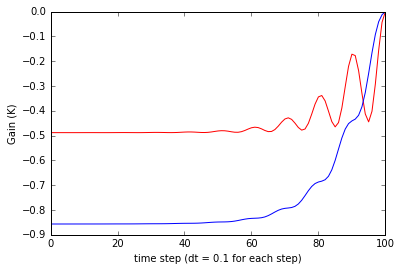

In [60]:
plt.plot(K[:, 0], c='r')
plt.plot(K[:, 1], c='b')
plt.ylabel('Gain (K)')
plt.xlabel('time step (dt = 0.1 for each step)')
plt.show()

Simulate the system using gain that we got from Riccati equation

where we can solve for control $u^\ast(t) = K(t) x^\ast (t) = -R^{-1}(t) B^T(t) P(t) x^\ast (t)$ 

where $K(t) = - R^{-1}(t) B^T(t) P(t)$

trajectory $x(t)$ can be solved by plug $u(t) = - K(t) x(t)$ into differential equation, i.e. 

$$\dot{\mathbf{x}} = A(t)\mathbf{x}(t) -  B R^{-1} (B^T) P(t) \mathbf{x}(t)$$

$$\dot{\mathbf{x}} = A(t)\mathbf{x}(t) +  B K(t) \mathbf{x}(t)$$


In [61]:
def solve_state_eq(x, t):
    """Solve state equation
    dx/dt = Ax + Bu
    """
    x = x[:, np.newaxis]
    # given A and K[t]
    Kt = np.atleast_2d(K[t])
    dxdt = A.dot(x) + B.dot(Kt.dot(x))
    return dxdt.ravel()

In [62]:
n = T/0.1 + 1
t = np.linspace(0, T, n) # time from 0 to final T = 10
x0 = np.array([1.0, 0.0]) # initial condition
xt = odeint(solve_state_eq, x0.ravel(), t) # solve Riccati equation over time

/Users/titipat/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


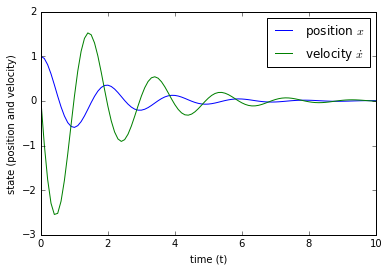

In [63]:
plt.plot(t, xt)
plt.xlabel('time (t)')
plt.ylabel('state (position and velocity)')
plt.legend(['position $x$', 'velocity $\dot{x}$'])
plt.show()

control signal $u(t)$ from time $t = 0$ to $T = 10$, here each time step, $dt = 0.1$

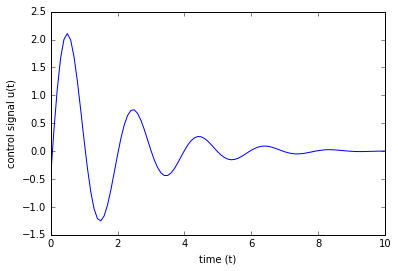

In [64]:
u = [np.dot(K[i], xt[i]) for i in range(len(K))] # control
plt.plot(t, u)
plt.xlabel('time (t)')
plt.ylabel('control signal u(t)')
plt.show()